In [1]:
import pandas
import pm4py
import csv
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from tqdm import tqdm 
from old_code.train import TrainSOM
from preprocessing import PreProcessing
from sklearn.decomposition import PCA
from pm4py.algo.querying.llm.abstractions import log_to_fea_descr
import intrasom
from intrasom.visualization import PlotFactory
from intrasom.clustering import ClusterFactory
import json


The preprocessing step cannot be executed due to data privacy, but from step 5 it is possible to use feature matrix to train SOM

### 1. Read M2C event-log files

In [2]:
event_log = pandas.read_csv("data/event_log_m2c.csv",  delimiter=",", encoding='utf-8')
case_attributes = pandas.read_csv("data/case_attributes_m2c.csv",  delimiter=",", encoding='cp1252', quoting=csv.QUOTE_NONE, quotechar='"')

/var/folders/hh/pvwk6s4917qdt0_j791cx6wc0000gn/T/ipykernel_31149/3309358021.py:2: DtypeWarning: Columns (9,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  case_attributes = pandas.read_csv("data/case_attributes_m2c.csv",  delimiter=",", encoding='cp1252', quoting=csv.QUOTE_NONE, quotechar='"')


### 2. Translate activities from german to english

In [3]:
with open('data/translation_dict.json') as json_data:
    data = json.load(json_data)

In [4]:
event_log.replace({'activity': data}, inplace=True)

### 3. Data pre-processing

In [5]:
event_log = pm4py.format_dataframe(event_log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')

In [8]:
file_name = 'data/extracted_features_l.csv'
features = PreProcessing.extract_features(event_log, case_attributes, file_name, activity_flag=1)

### 4. Create and save feature matrix 

In [9]:
feature_matrix = PreProcessing.create_feature_matrix(features)

In [10]:
with open('feature_matrix_l.npy', 'wb') as f:
    np.save(f, feature_matrix)

### 5. Load feature matrix - from here the data is available in GitHub repository 

In [11]:
with open('L_setting/feature_matrix_l.npy', 'rb') as f:
    feature_matrix = np.load(f)

In [12]:
feature_matrix

array([[0.        , 0.02083333, 0.04166667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1875    , 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02083333, 0.04166667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.68732635, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.08333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.08333333, 0.        , ..., 0.        , 0.        ,
        0.        ]])

### 7. Initialize SOM

Configure SOM

In [16]:
som_width, som_height, num_neurons, num_iterations = TrainSOM.config_som(features)
f = features.drop(columns=['case_id'])
print(som_width, som_height, num_neurons, num_iterations)

62 64 3935 1967500


In [17]:
mapsize = (som_width, som_height)
som = intrasom.SOMFactory.build(feature_matrix,
                                        mask=None,
                                        mapsize=mapsize,
                                        mapshape='toroid',
                                        lattice='hexa',
                                        normalization=None,
                                        initialization='random',
                                        neighborhood='gaussian',
                                        training='batch',
                                        name='Example',
                                        component_names=f.columns.to_list(),
                                        unit_names = None,
                                        sample_names=None,
                                        missing=False,
                                        save_nan_hist = False,
                                        pred_size=0)

Loading dataframe...
Normalizing data...
Creating neighborhood...
Initializing map...


Creating Neuron Distance Rows:   0%|          | 0/64 [00:00<?, ?rows/s]

In [18]:
som.train(n_job=4, train_len_factor=2, previous_epoch = True)

Starting Training...
Rough Training:


  0%|          | 0/2 [00:00<?, ?it/s]

Fine Tuning:


  0%|          | 0/2 [00:00<?, ?it/s]

Saving...
Training Report Created
Training completed successfully.


In [13]:
bmus = pandas.read_parquet("L_setting/Results/Example_neurons.parquet")
params = json.load(open("L_setting/Results/params_Example.json", encoding='utf-8'))
som_vis = intrasom.SOMFactory.load_som(data = feature_matrix,
                                       trained_neurons = bmus,
                                       params = params)

Loading data...
Loading dataframe...
Normalizing data...
Creating neighborhood...
Creating missing data database
Creating codebook...
Loading distances matrix...
Initializing map...


Creating Neuron Distance Rows:   0%|          | 0/64 [00:00<?, ?rows/s]

### 8. Visualize results

In [14]:
plot = PlotFactory(som_vis)

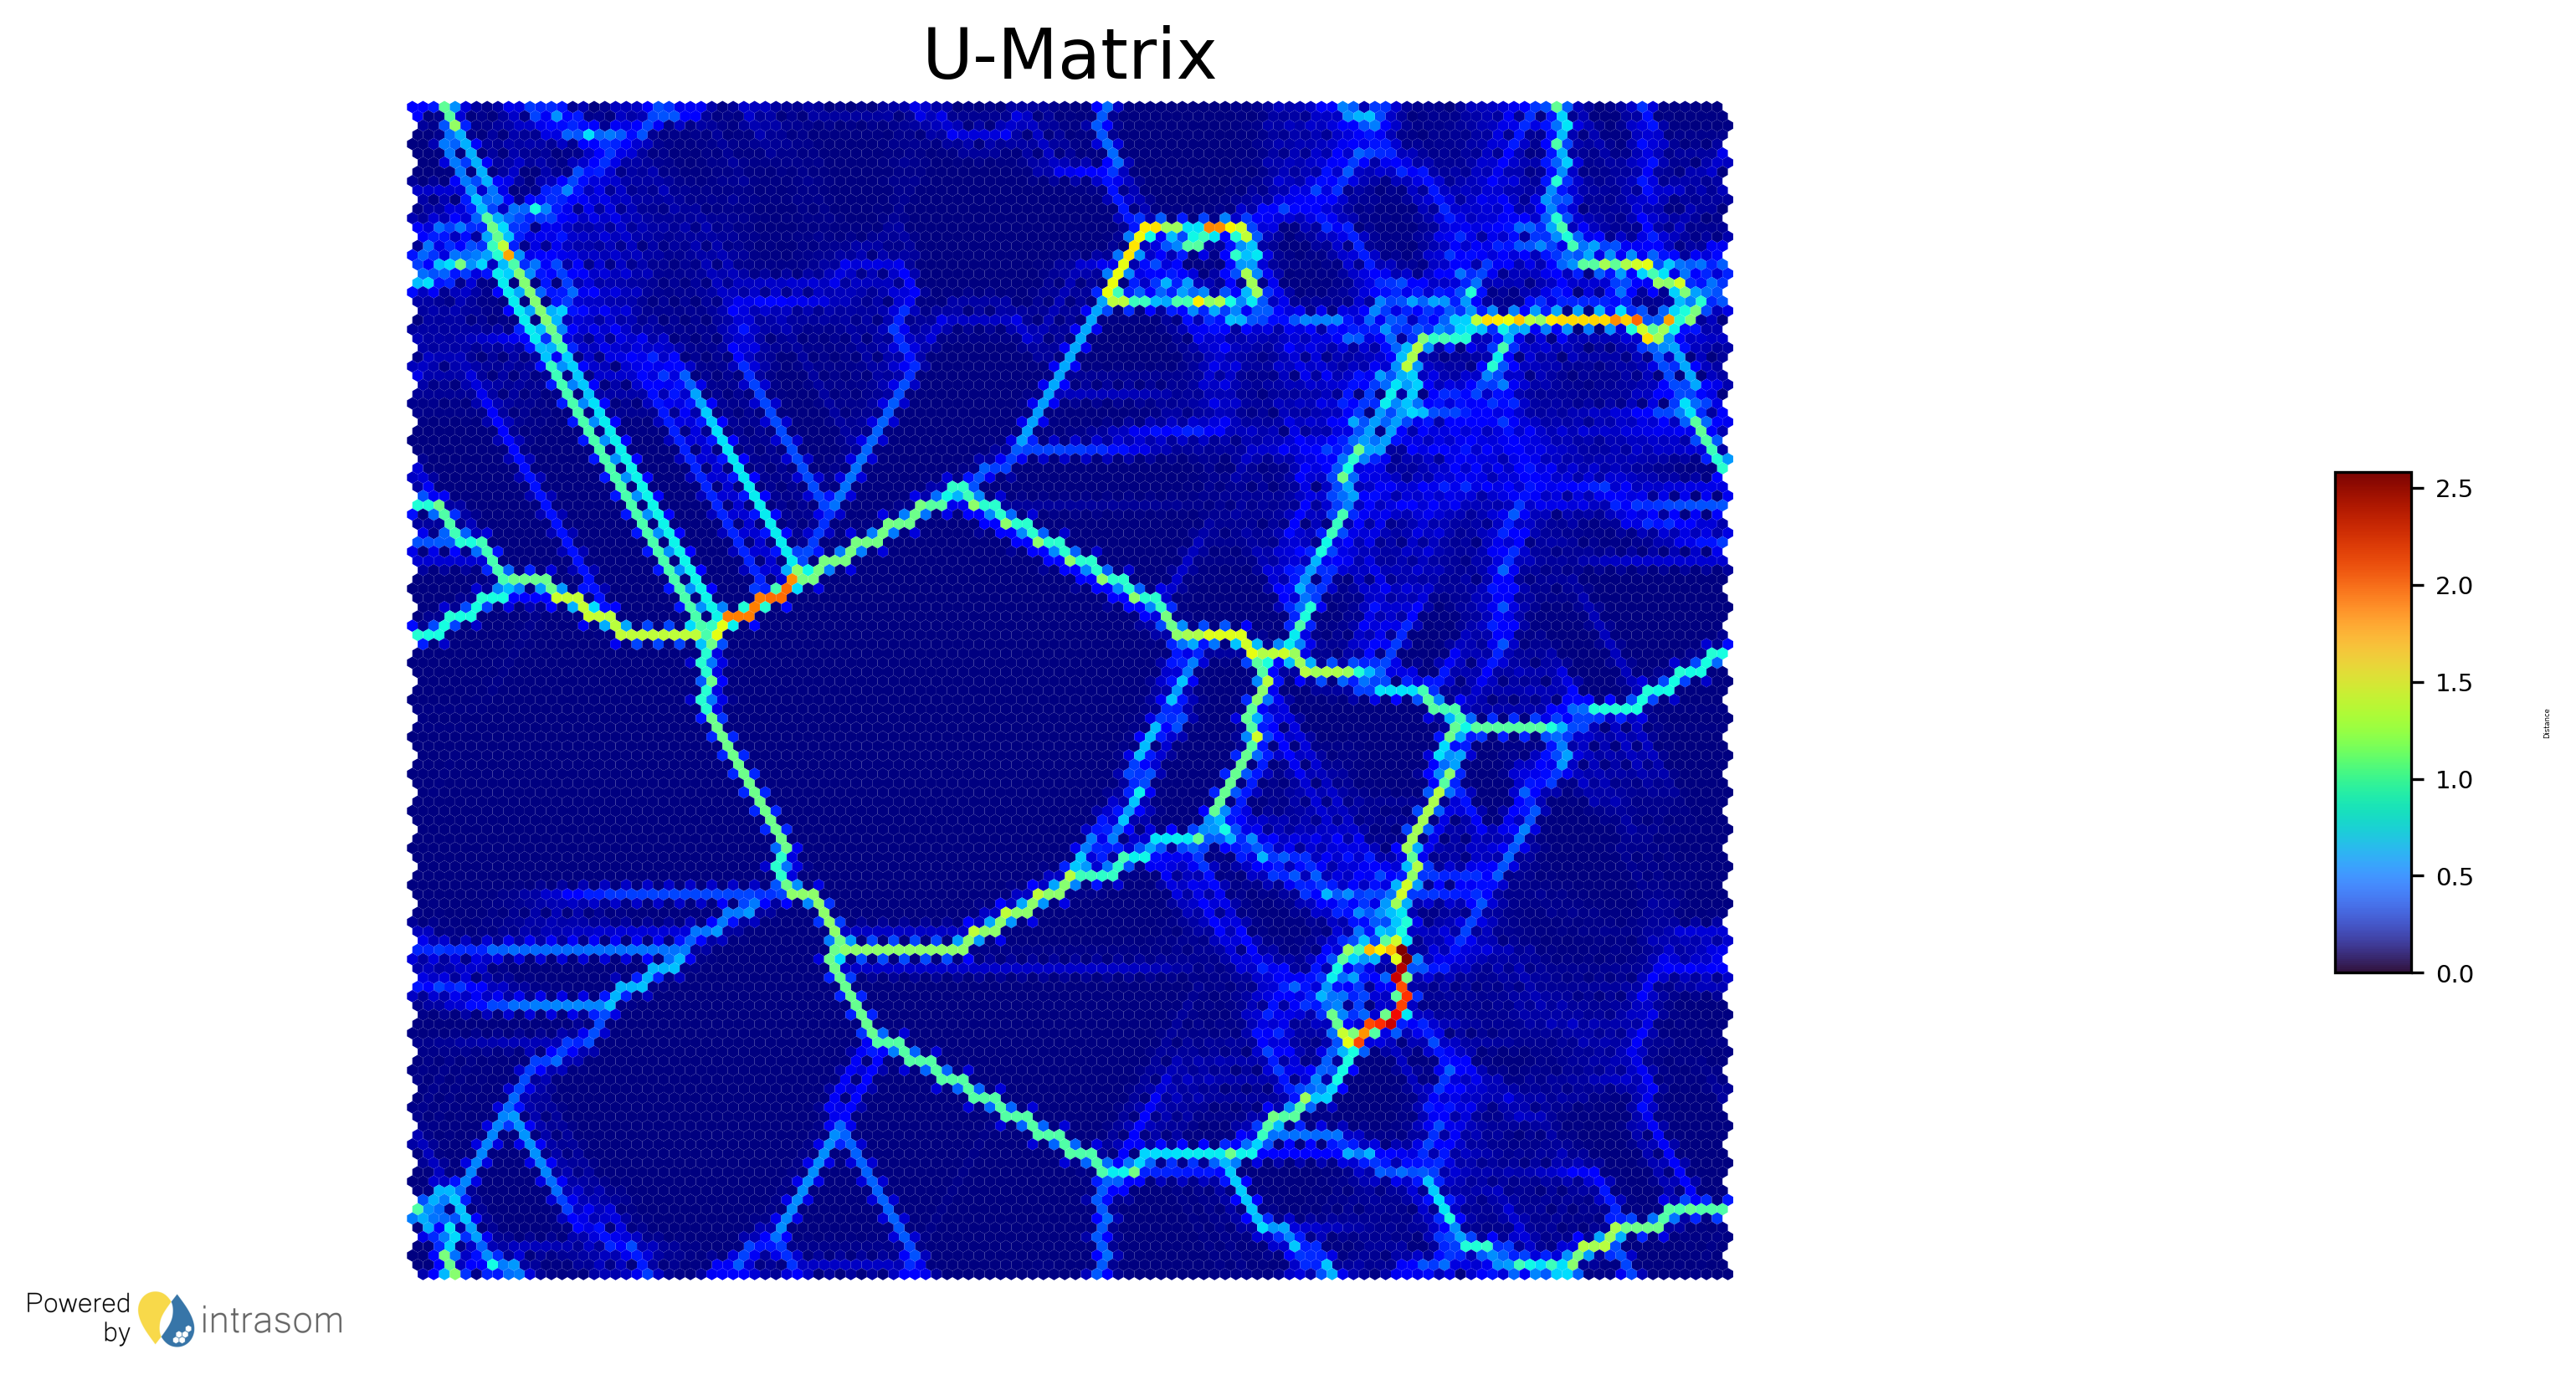

Saving.


In [59]:
plot.plot_umatrix(figsize = (13,2.5),
                  hits = False,
                  title = "U-Matrix",
                  title_size = 20,
                  title_pad = 20,
                  legend_title = "Distance",
                  legend_title_size = 12,
                  legend_ticks_size = 7,
                  label_title_xy = (0,0.5),
                  save = True,
                  file_name = "umatrix",
                  file_path = '',
                  watermark_neurons=False)

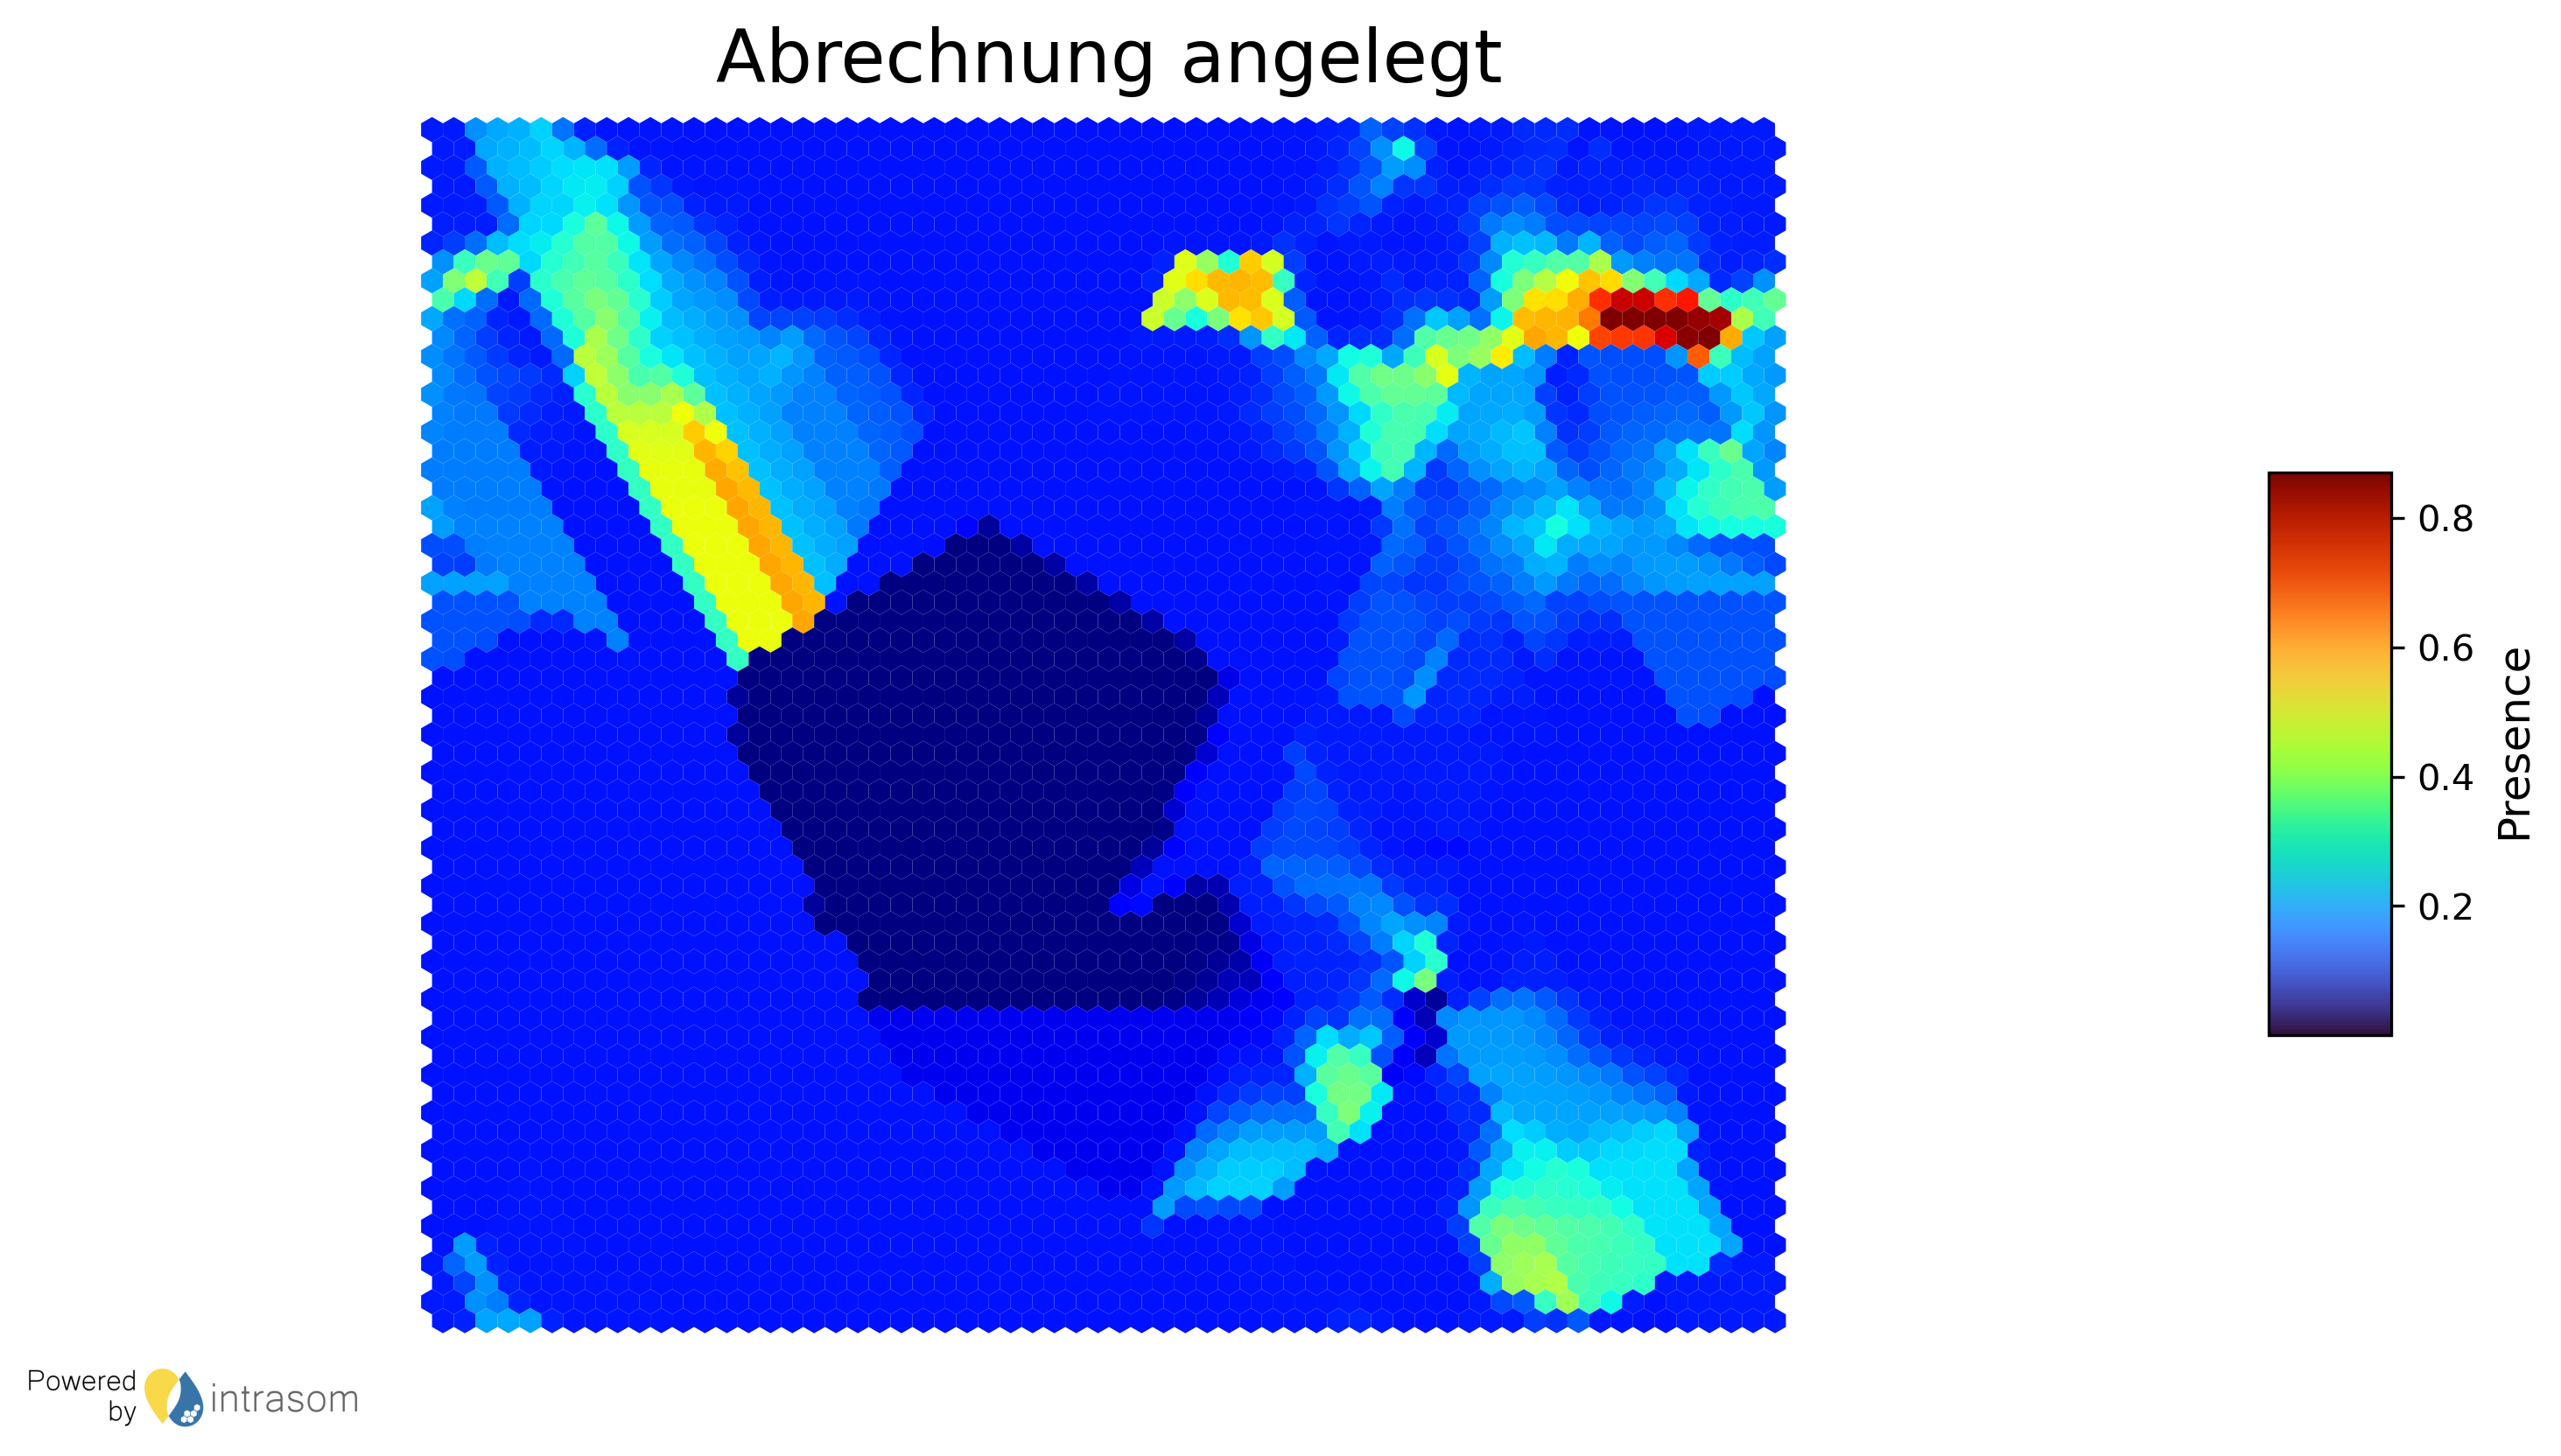

In [65]:
plot.component_plot(figsize = (12,2.5),
                    component_name=13,
                    title_size = 20,
                    legend_title = "Presence",
                    legend_pad = 5,
                    legend_title_size = 12,
                    legend_ticks_size = 10,
                    label_title_xy = (0,0.7))

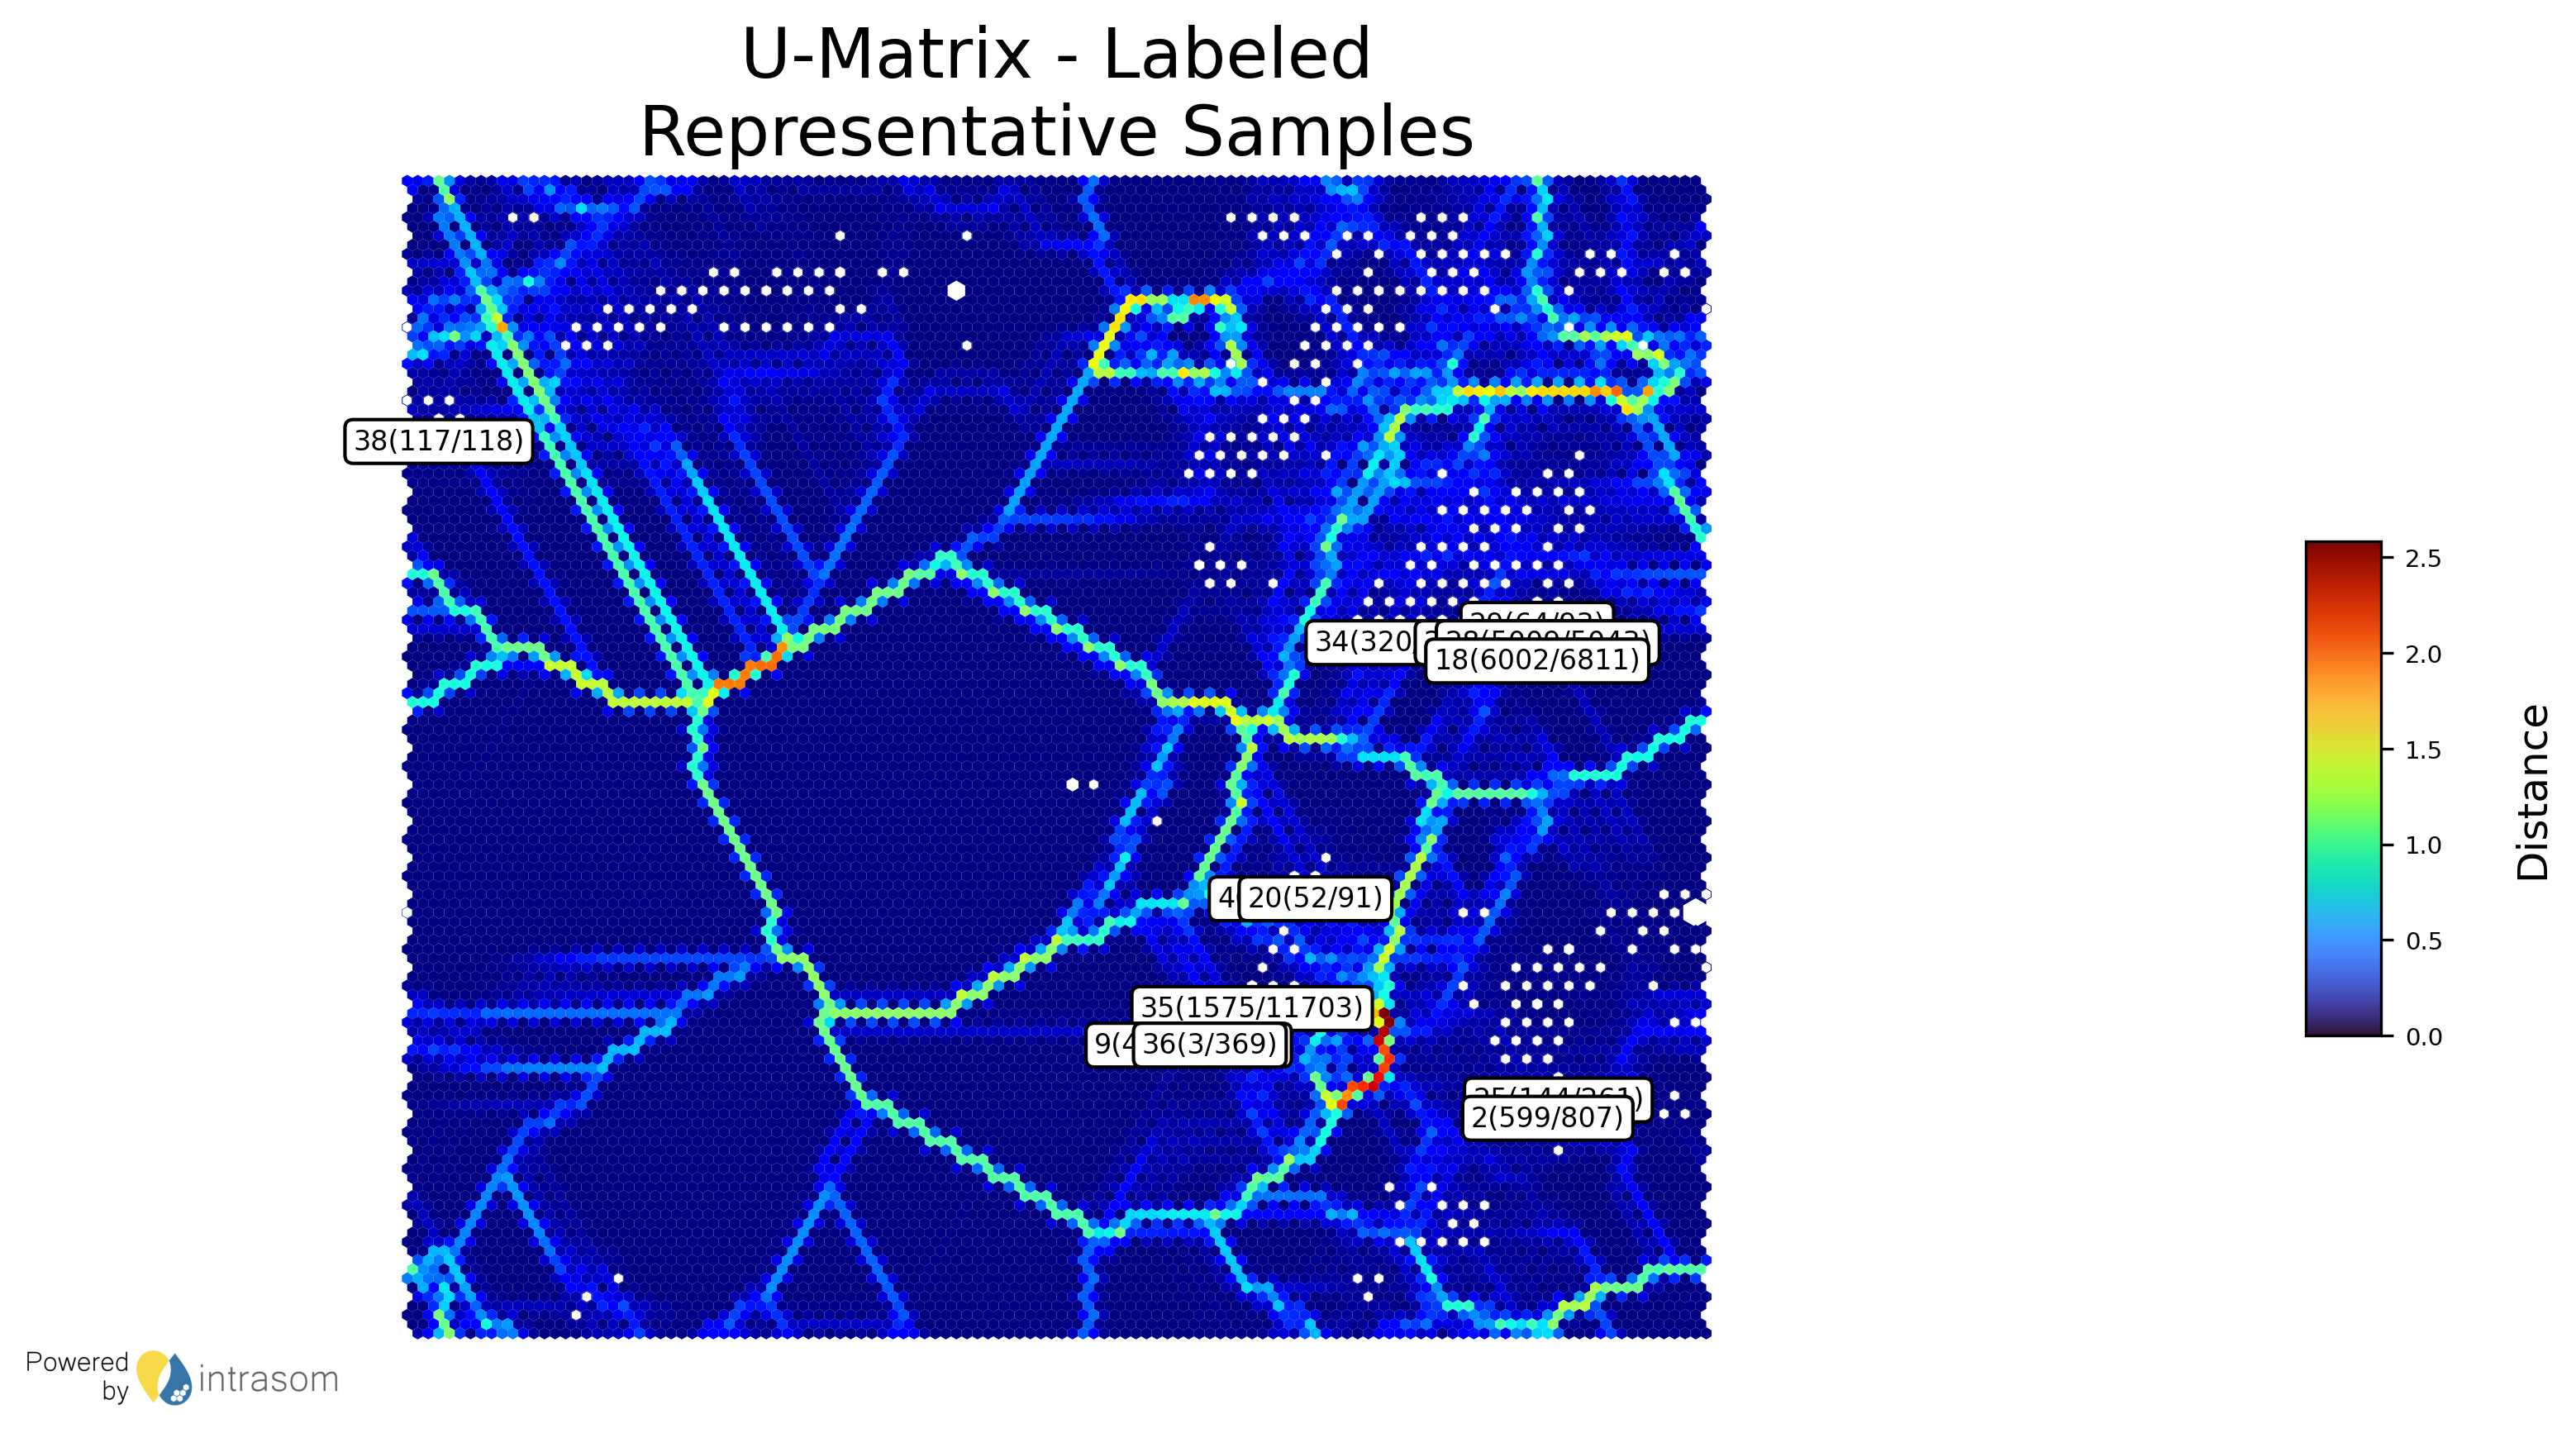

In [66]:
plot.plot_umatrix(figsize = (13,2.5),
                  hits = True,
                  title = "U-Matrix - Labeled Representative Samples",
                  title_size = 20,
                  title_pad = 20,
                  legend_title = "Distance",
                  legend_title_size = 12,
                  legend_ticks_size = 7,
                  label_title_xy = (0,0.5),
                  save = False,
                  file_name = "umatrix_sample_labels",
                  file_path = False,
                  watermark_neurons=False,
                  samples_label = True,
                  samples_label_index = range(40),
                  samples_label_fontsize = 8,
                  save_labels_rep = True)

#### 9. Clustering K-Means

In [24]:
clustering = ClusterFactory(som_vis)
clusters_10 = clustering.kmeans(k=10)
clusters_20 = clustering.kmeans(k=20)
clusters_30 = clustering.kmeans(k=30)
cases_10 = clustering.results_cluster(clusters_10)
cases_10['case_id'] = features['case_id'].values
cases_20 = clustering.results_cluster(clusters_20)
cases_20['case_id'] = features['case_id'].values
cases_30 = clustering.results_cluster(clusters_30)
cases_30['case_id'] = features['case_id'].values
cases_10.to_csv("L_setting/clusters_10.csv", index=False)
cases_20.to_csv("L_setting/clusters_20.csv", index=False)
cases_30.to_csv("L_setting/clusters_30.csv", index=False)

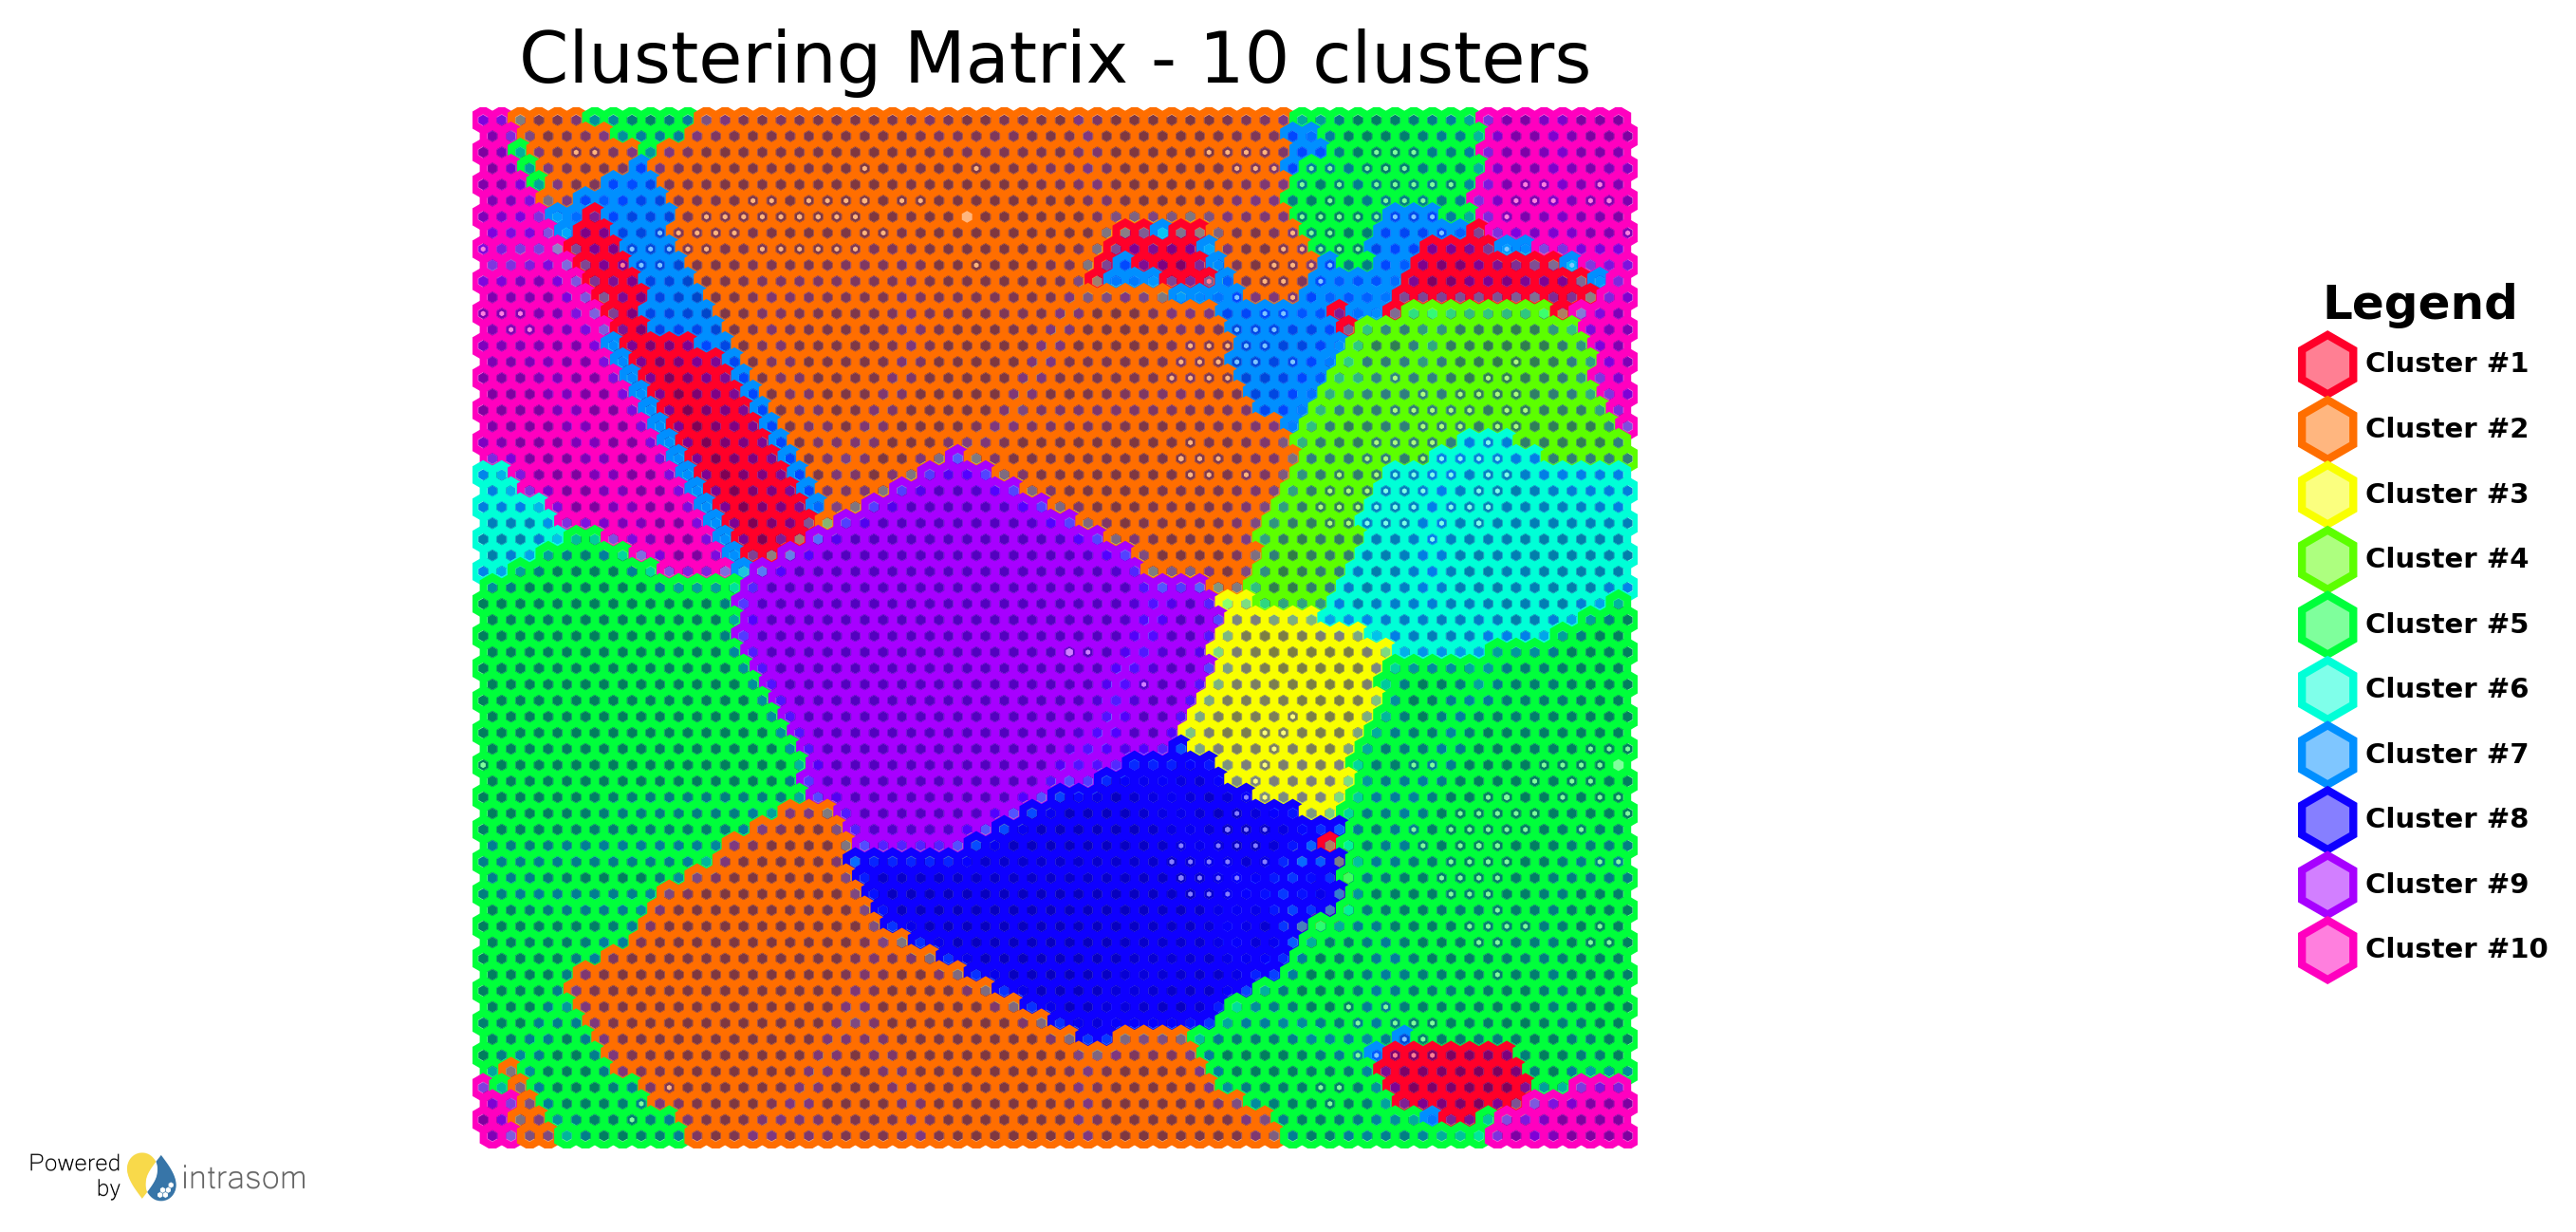

In [25]:
clustering.plot_kmeans(figsize = (12,5),
                       clusters = clusters_10,
                       title_size = 18,
                       title_pad = 20,
                       umatrix=True,
                       colormap = "gist_rainbow",
                       alfa_clust=0.5,
                       hits=True,
                       legend_text_size =7,
                       cluster_outline=False,
                       save=True,
                       file_name="cluster_gist_10")

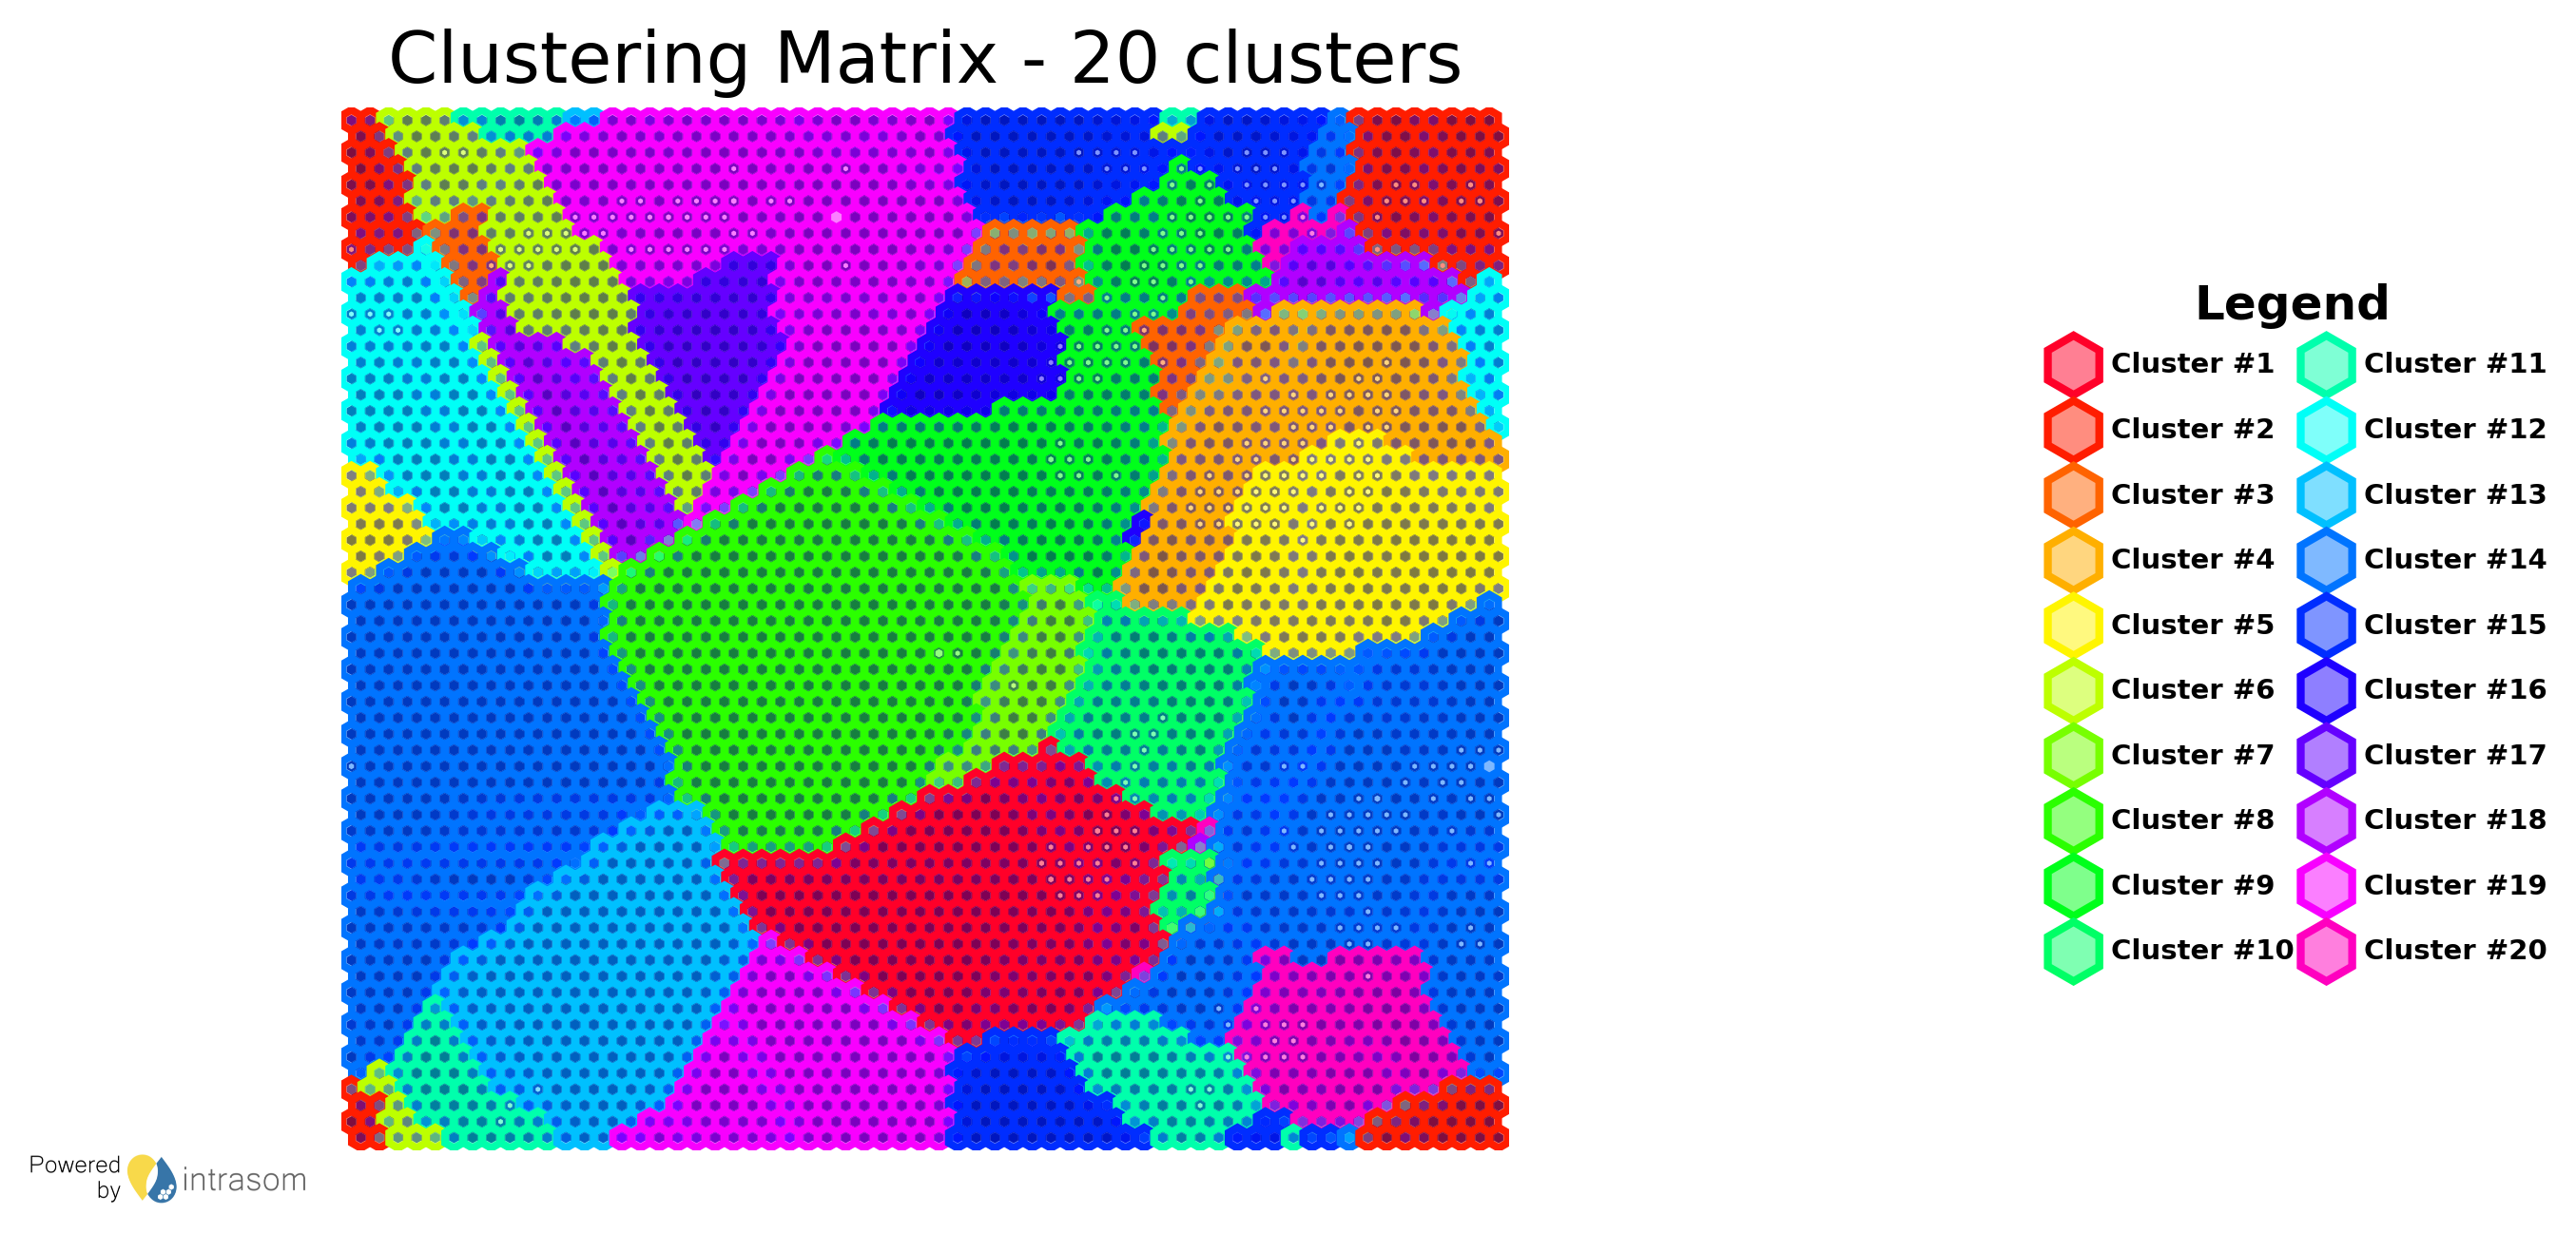

In [26]:
clustering.plot_kmeans(figsize = (12,5),
                       clusters = clusters_20,
                       title_size = 18,
                       title_pad = 20,
                       umatrix=True,
                       colormap = "gist_rainbow",
                       alfa_clust=0.5,
                       hits=True,
                       legend_text_size =7,
                       cluster_outline=False,
                       save=True,
                       file_name="cluster_gist_20")

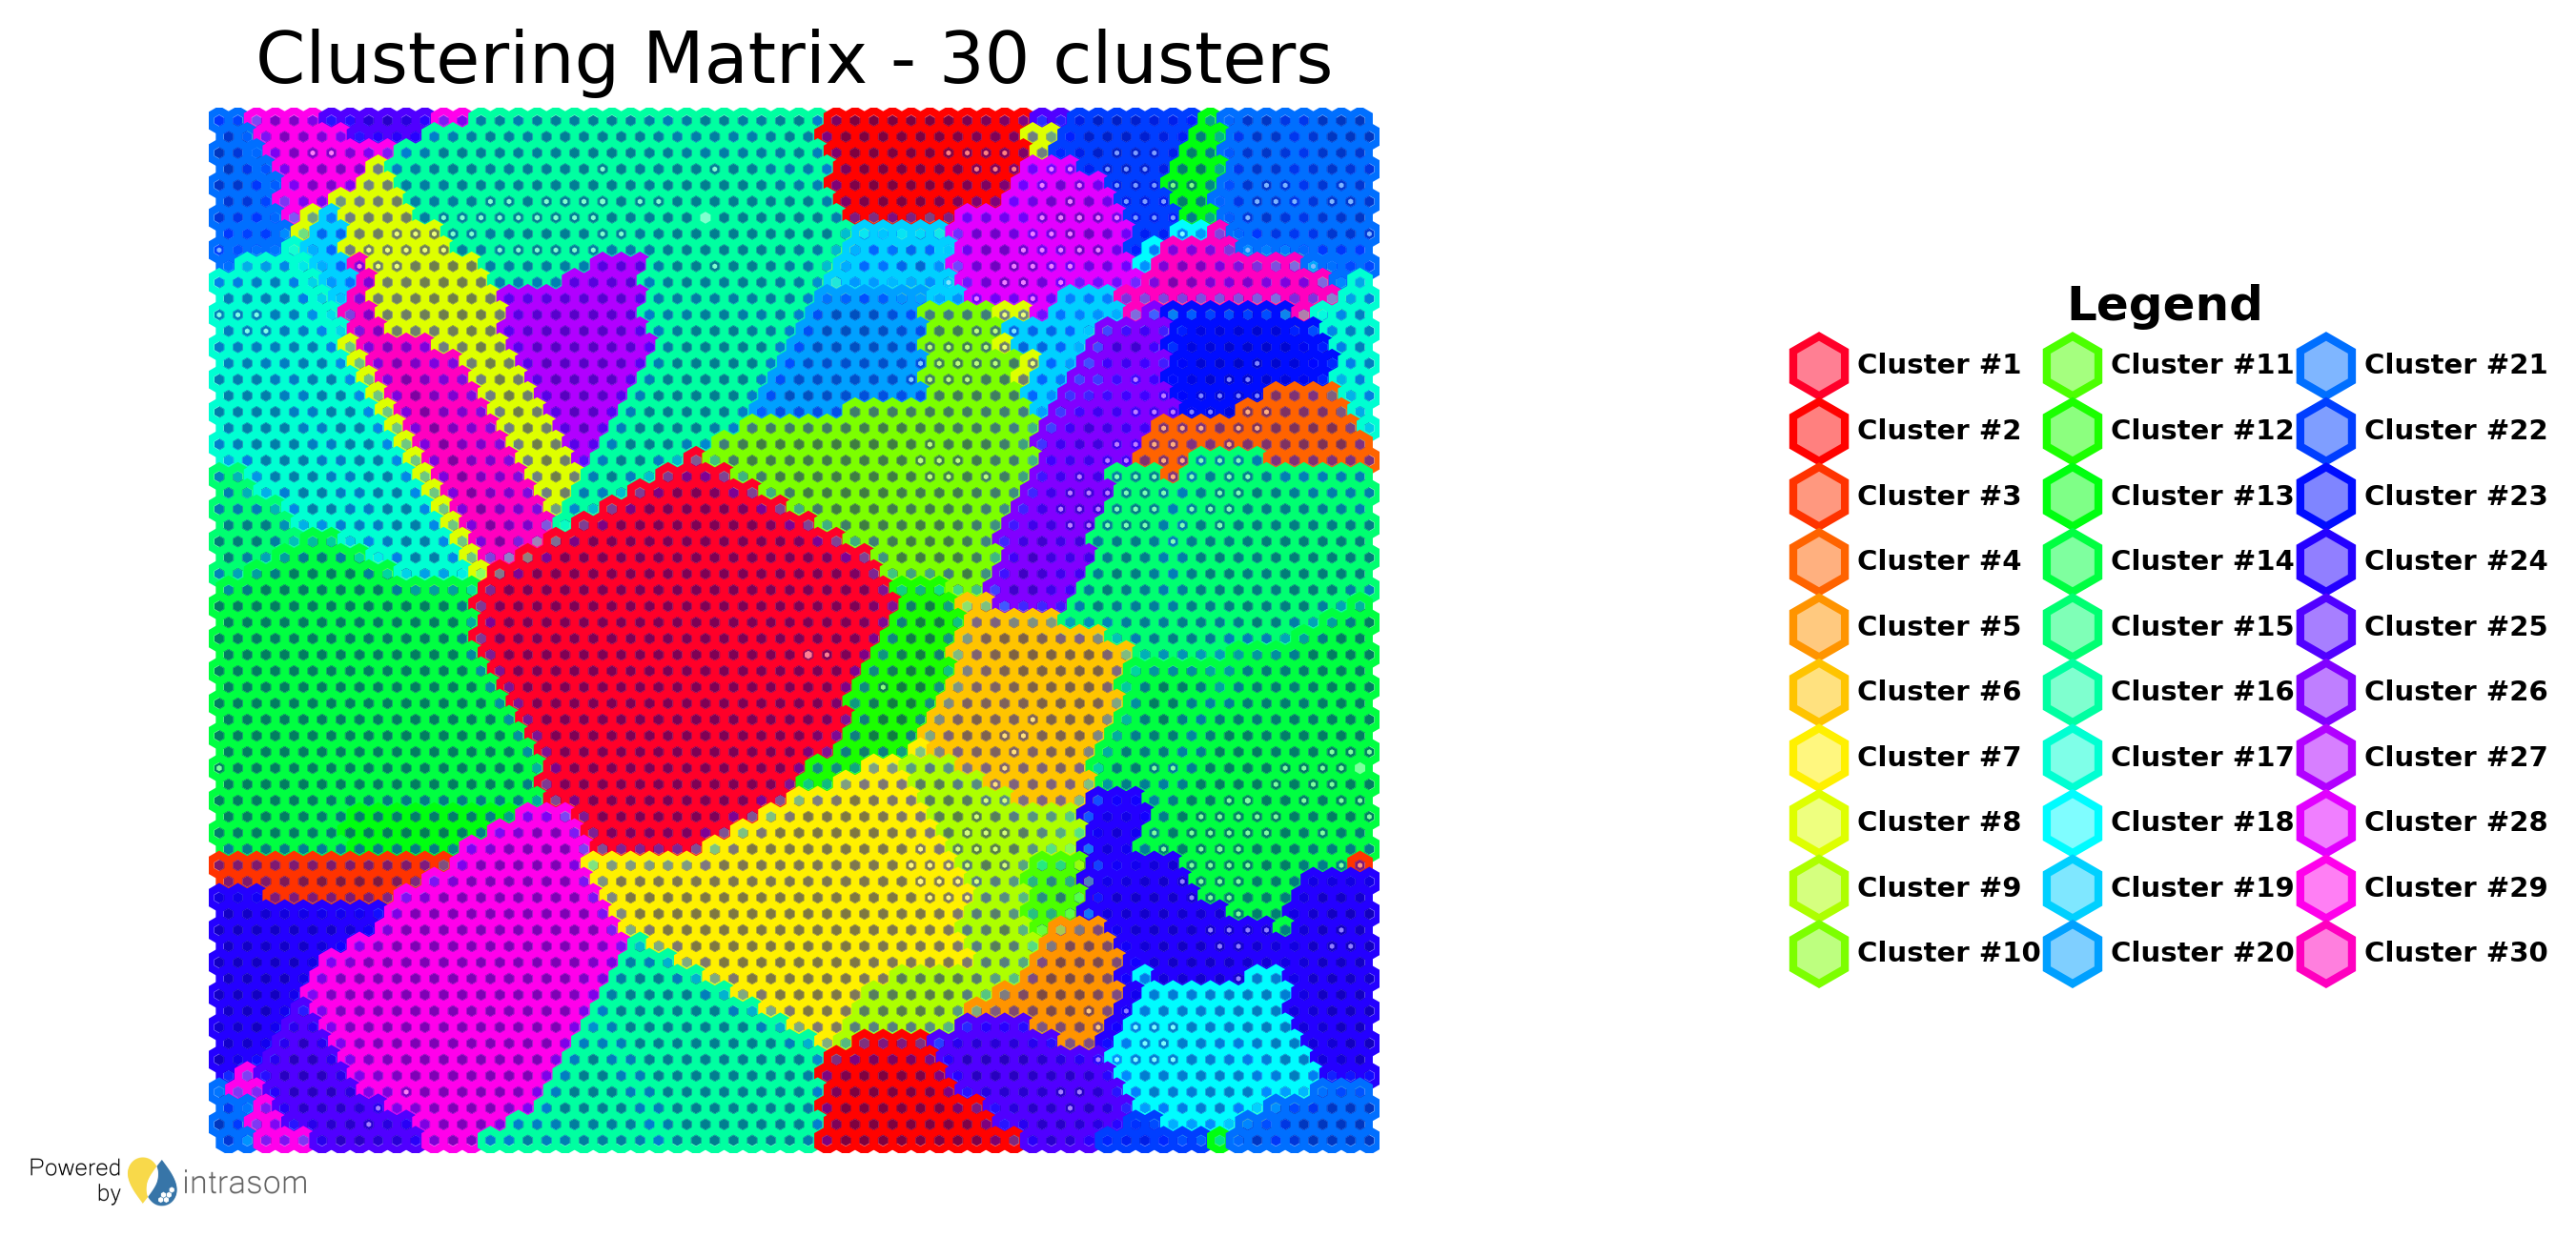

In [27]:
clustering.plot_kmeans(figsize = (12,5),
                       clusters = clusters_30,
                       title_size = 18,
                       title_pad = 20,
                       umatrix=True,
                       colormap = "gist_rainbow",
                       alfa_clust=0.5,
                       hits=True,
                       legend_text_size =7,
                       cluster_outline=False,
                       save=True,
                       file_name="cluster_gist_30")

### 10. Visualize clustered process flows

In [39]:
feature_matrix = pandas.read_csv("L_setting/clusters_30.csv",  delimiter=",", encoding='utf-8', quoting=csv.QUOTE_NONE, quotechar='"')

In [40]:
count_clusters = feature_matrix.groupby('30_clusters').size().reset_index(name='count_clusters')

In [41]:
count_clusters

30_clusters  count_clusters
0             1           46410
1             2             321
2             3               1
3             4             317
4             5              16
5             6            1036
6             7           17975
7             8            2284
8             9           11875
9            10           19853
10           12             112
11           13             257
12           14          310503
13           15           18882
14           16          166121
15           17             477
16           18             298
17           19              17
18           20             328
19           21            8283
20           22            2403
21           23             267
22           24            4317
23           25             253
24           26             714
25           28            6042
26           29              32
27           30               3

In [49]:
selected_df = feature_matrix[feature_matrix['30_clusters'] == 19][['case_id']]

In [50]:
event_log_filtered = event_log[event_log['case_id'].isin(selected_df['case_id'].unique())]

event_log_ = event_log_filtered.sort_values(by=['case_id', 'timestamp', 'SORTKEY'])

event_log_tr = pm4py.format_dataframe(event_log_filtered, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
dfg, start_activities, end_activities = pm4py.discover_performance_dfg(event_log_tr, activity_key='activity', case_id_key='case_id', timestamp_key='timestamp')
pm4py.save_vis_performance_dfg(dfg, start_activities, end_activities, 'l_cluster_19_P.png')

''